<a href="https://colab.research.google.com/github/DanielAlvaradejo/challengeLatam-data-science-robot-trading/blob/main/Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lógica básica

La primer parte de este robot se basa en una lógica simple pero efectiva, la cual verifica los siguientes parámetros para que el robot haga una toma de decisión

Si el precio actual es mayor/igual que el precio promedio y la tendencia es de baja, entonces guarda el valor ‘Vender’.

Si el precio actual es menor que el precio promedio y la tendencia es de alta, entonces guarda el valor ‘Comprar’.

Si ninguna de las 2 condiciones anteriores se cumple, entonces guarda el valor 'Esperar'.

##Preparando el ambiente

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

##Extrayendo Datos

###Precios historicos del Bitcoin

In [3]:
def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  # Obtener datos históricos del Bitcoin en dólares (BTC-USD)
  bitcoin_data = yf.download(tickers='BTC-USD', period='7d', interval='5m')

  # Guardar los datos en un dataframe
  df_bitcoin = pd.DataFrame(bitcoin_data)

In [4]:
importar_base_bitcoin()
df_bitcoin.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-03-29 00:00:00+00:00,70784.898438,70829.468750,70764.921875,70829.468750,70829.468750,0
2024-03-29 00:05:00+00:00,70815.578125,70822.484375,70748.843750,70752.718750,70752.718750,0
2024-03-29 00:10:00+00:00,70749.148438,70749.148438,70734.085938,70736.343750,70736.343750,0
2024-03-29 00:15:00+00:00,70734.351562,70775.875000,70732.062500,70755.335938,70755.335938,0
2024-03-29 00:20:00+00:00,70743.117188,70743.117188,70717.546875,70728.773438,70728.773438,0


### Indicadores de Tendencias

In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def importar_CoinMarket():
    global df_CoinMarket,precio_actualC,tendenciaC
    url = "https://coinmarketcap.com/es/"

    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    tabla = soup.find('table')  # Ajusta esto para seleccionar la tabla correcta

    # Lista de datos vacía para almacenar los nuevos datos
    nuevos_datos = []

    # Extrae la información de la tabla
    for fila in tabla.find_all('tr'):
        columnas = fila.find_all('td')
        fila_datos = []
        if len(columnas) >= 5:  # Nos aseguramos de que haya suficientes columnas
            # Almacenamos los datos de la tercera, cuarta y quinta columna
            valor_tercera_columna = columnas[2].text.strip()
            valor_cuarta_columna = columnas[3].text.strip()
            valor_quinta_columna = columnas[4].text.strip()
            span = columnas[4].find('span')
            clase_span = ' '.join(span.get('class')) if span and span.get('class') else None
            # Añadimos un signo menos a los valores en la quinta columna si la clase del span es "sc-6a54057-0 iEhQde"
            if clase_span == 'sc-6a54057-0 iEhQde':
                valor_quinta_columna = '-' + valor_quinta_columna
            # Creamos la columna de tendencia
            tendencia = "Alta" if clase_span == "sc-6a54057-0 YXxPZ" else "Baja"
            fila_datos.extend([valor_tercera_columna, valor_cuarta_columna, valor_quinta_columna, clase_span, tendencia])
            nuevos_datos.append(fila_datos)

    # Convierte los nuevos datos en un DataFrame de pandas
    df_CoinMarket = pd.DataFrame(nuevos_datos, columns=['Moneda', 'Precio Actual', '1h %', 'Clase_del_Span', 'Tendencia'])

    # Selecciona solo las primeras 5 filas
    df_CoinMarket = df_CoinMarket.head(5)

    # Guardar el valor de la columna 2, fila 1 (Precio Actual) en la variable precio_actual
    precio_actual_str = df_CoinMarket.loc[0, 'Precio Actual']
    precio_actual_str = precio_actual_str.replace('$', '').replace(',', '')  # Eliminar el signo de $ y reemplazar la coma por un punto
    precio_actualC = float(precio_actual_str.replace(',', '.'))  # Convertir a float

    # Guardar el valor de la columna 5, fila 1 (Tendencia) en la variable tendencia
    tendenciaC = df_CoinMarket.loc[0, 'Tendencia']


importar_CoinMarket()
df_CoinMarket

,Moneda,Precio Actual,1h %,Clase_del_Span,Tendencia
0,BitcoinBTC,"$67,653.30",-0.09%,sc-6a54057-0 iEhQde,Baja
1,EthereumETH,"$3,365.23",-0.55%,sc-6a54057-0 iEhQde,Baja
2,Tether USDtUSDT,$1.00,-0.02%,sc-6a54057-0 iEhQde,Baja
3,BNBBNB,$590.87,-0.41%,sc-6a54057-0 iEhQde,Baja
4,SolanaSOL,$187.25,-0.68%,sc-6a54057-0 iEhQde,Baja


In [6]:
def importar_Binance():
    global precio_actualB, tendenciaB

    url = "https://www.binance.com/es-MX/price/bitcoin"

    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
    div_con_clase = soup.find('div', class_='css-1bwgsh3')

    precio_actualB = div_con_clase.text.strip()

    divs_vurnku = soup.find_all('div', class_='css-vurnku')

    for div_vurnku in divs_vurnku:
        if 'Price Change (1h)' in div_vurnku.text:
            div_wt5iqc = div_vurnku.find_parent('div', class_='css-wt5iqc')
            if div_wt5iqc:
                div_ip5vzp_sibling = div_wt5iqc.find_next_sibling('div', class_='css-1ip5vzp')
                if div_ip5vzp_sibling:
                    nombre_clase_div_child = div_ip5vzp_sibling.find('div').get('class')[0]
                    tendencia_valor = nombre_clase_div_child
                    if tendencia_valor == "css-13n52y":
                      tendenciaB = "Alta"
                    else:
                      tendenciaB = "Baja"
                    break
            break
importar_Binance()

In [7]:
def extraer_tendencia():
  global tendencia, df_CoinMarket, precio_actual

  #Precio y tendencia extraídos de Binance
  print("El precio extraído de Binance es:", precio_actualB, "y la tendencia es", tendenciaB)

  #Precio y tendencia extraídos de CoinMarket
  print("El precio extraído de CoinMarket es:", precio_actualC, "y la tendencia es", tendenciaC)


In [8]:
extraer_tendencia()

El precio extraído de Binance es: $ 67,627.12 y la tendencia es Baja
El precio extraído de CoinMarket es: 67653.3 y la tendencia es Baja


## Limpieza de datos


In [9]:
print(df_bitcoin.info())
df_bitcoin.describe().round(0)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1921 entries, 2024-03-29 00:00:00+00:00 to 2024-04-04 16:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1921 non-null   float64
 1   High       1921 non-null   float64
 2   Low        1921 non-null   float64
 3   Close      1921 non-null   float64
 4   Adj Close  1921 non-null   float64
 5   Volume     1921 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 105.1 KB
None


,Open,High,Low,Close,Adj Close,Volume
count,1921.0,1921.0,1921.0,1921.0,1921.0,1.921000e+03
mean,68521.0,68558.0,68483.0,68520.0,68520.0,2.793040e+07
std,1991.0,1979.0,2001.0,1990.0,1990.0,6.581024e+07
min,64611.0,64835.0,64583.0,64610.0,64610.0,0.000000e+00
25%,66249.0,66271.0,66206.0,66244.0,66244.0,0.000000e+00
50%,69600.0,69636.0,69571.0,69601.0,69601.0,0.000000e+00
75%,70128.0,70155.0,70100.0,70128.0,70128.0,2.905702e+07
max,71323.0,71355.0,71268.0,71355.0,71355.0,1.375314e+09


<Axes: >

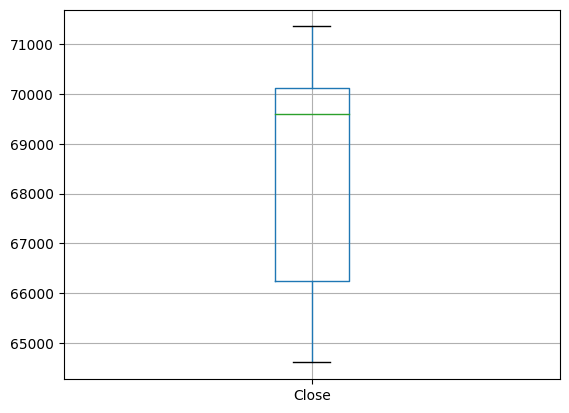

In [10]:
df_bitcoin.boxplot(['Close'])

In [11]:
def limpieza_datos():
    global df_bitcoin_limpio, df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision

    # Realizar una copia del DataFrame df_bitcoin
    df_bitcoin_limpio = df_bitcoin.copy()

    # Eliminar la columna 'Adj Close' y restablecer el índice
    df_bitcoin_limpio = df_bitcoin_limpio.drop('Adj Close', axis=1).reset_index()

    # Buscar valores nulos en la columna "Close"
    valores_nulos = df_bitcoin_limpio["Close"].isnull().sum()
    if valores_nulos > 0:
        # Tratar los valores nulos (por ejemplo, reemplazarlos con un valor promedio)
        df_bitcoin_limpio["Close"].fillna(df_bitcoin_limpio["Close"].mean(), inplace=True)

    # Filtrar los registros con volumen de transacción mayor a 0
    df_bitcoin_limpio = df_bitcoin_limpio[df_bitcoin_limpio["Volume"] > 0]

    # Calcular el rango intercuartílico (IQR)
    Q1 = df_bitcoin_limpio["Close"].quantile(0.25)
    Q3 = df_bitcoin_limpio["Close"].quantile(0.75)
    IQR = Q3 - Q1

    # Calcular los límites interiores e exteriores
    limite_interior_inferior = Q1 - 1.5 * IQR
    limite_exterior_inferior = Q1 - 3 * IQR
    limite_interior_superior = Q3 + 1.5 * IQR
    limite_exterior_superior = Q3 + 3 * IQR

    # Filtrar los registros dentro de los límites interiores
    df_bitcoin_limpio = df_bitcoin_limpio[(df_bitcoin_limpio["Close"] >= limite_interior_inferior) &
                                          (df_bitcoin_limpio["Close"] <= limite_interior_superior)]

    # Calcular el precio promedio del Bitcoin (Close)
    media_bitcoin = df_bitcoin_limpio["Close"].mean()
    print(f"Precio promedio del Bitcoin (Close): ${media_bitcoin:.2f}")

In [12]:
limpieza_datos()

Precio promedio del Bitcoin (Close): $68510.53


##Toma de decisiones

###Toma de decisiones básica

In [13]:
from ast import And
def tomar_decisiones():
      global df_bitcoin_limpio, df_bitcoin, precio_actualC, tendenciaC, media_bitcoin, algoritmo_decision

      if precio_actualC >= media_bitcoin and tendenciaC == 'Baja':
        algoritmo_decision = 'Vender'
      elif precio_actualC < media_bitcoin and tendenciaC == 'Alta':
        algoritmo_decision = 'Comprar'
      else:
        algoritmo_decision = 'Esperar'
      print('Utilizando el algoritmo básico')
      print(f'La recomendación es: {algoritmo_decision}')

In [14]:
type(precio_actualC)
tomar_decisiones()

Utilizando el algoritmo básico
La recomendación es: Esperar


##Visualización

In [15]:
def visualizacion_basica():
      global df_bitcoin_limpio, df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
      df_bitcoin_limpio[['Promedio']] = media_bitcoin

          # Configurar el tamaño del gráfico en una proporción de 16x5
      plt.figure(figsize=(16, 5))

      # Adicionar un título al gráfico
      plt.title('Precio de Bitcoin vs. Precio Promedio (báscio)')

      # Dibujar una línea con los datos del índice y la columna Close
      df_bitcoin_limpio['Close'].plot(label='Precio de Bitcoin')

      # Dibujar una línea con los datos del índice y la columna Promedio
      df_bitcoin_limpio['Promedio'].plot(label='Precio Promedio')

      # Mostrar un mensaje con la decisión del algoritmo
      plt.annotate(algoritmo_decision, xy=(df_bitcoin_limpio.index[-1], df_bitcoin_limpio['Close'].iloc[-1]),
                  xytext=(df_bitcoin_limpio.index[-1], df_bitcoin_limpio['Close'].iloc[-1] + 500),
                  arrowprops=dict(facecolor='black', arrowstyle='->'),
                  fontsize=12)

      # Mostrar el gráfico
      plt.legend()
      plt.show()


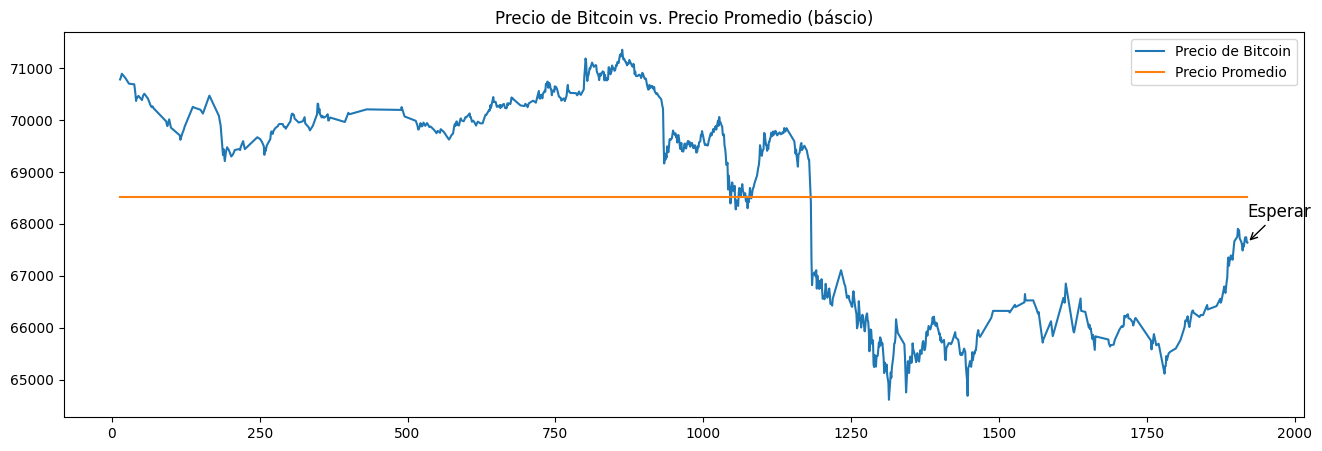

In [16]:
visualizacion_basica()

##Automatización

#Oscilador Estocastico - Medias Móviles Exponenciales Convergentes/Divergentes (MACD)

1.  **Tendencia:** Esta es una medida de la dirección general del precio de una criptomoneda. Puede ser alcista (subiendo) o bajista (bajando).

2.  **Osciladores de impulso:** Estos son indicadores técnicos que utilizan la velocidad y el cambio de los movimientos de precios para generar señales de trading.

3.  **Línea de tendencia:** Una característica clave del indicador es la línea de tendencia, que cuando el precio cruza hacia arriba, indica que se puede imprimir una señal larga, y a la inversa, cuando el precio cruza hacia abajo indica que se puede imprimir una señal corta.



##Oscilador Estocástico

Este oscilador compara el precio de cierre de un activo con su rango de precios durante un período de tiempo específico. La fórmula para calcular el Oscilador Estocástico es la siguiente:



$\%K = \left( \frac{C - L_{14}}{H_{14} - L_{14}} \right) \times 100$

Donde:

$C$ es el precio de cierre más reciente.

$L_{14}$ es el precio más bajo registrado durante los últimos 14 períodos.

$H_{14}$ es el precio más alto registrado durante los últimos 14 períodos.



---


La fórmula para calcular el %D, la media móvil de n períodos del %K, es:



$\%D = \text{Media Móvil de } \%K \text{ en } n \text{ períodos}$


In [17]:
precios_ultimos_14_periodos = []


def precios_oscilador_estocastico():
    global precio_actualC, precio_mas_bajo, precio_mas_alto

      # Agrega el precio actual a la lista de precios de los últimos 14 periodos
    precios_ultimos_14_periodos.append(precio_actualC)

    # Si la longitud de la lista de precios supera los 14 periodos, remueve el primer elemento
    if len(precios_ultimos_14_periodos) > 14:
        precios_ultimos_14_periodos.pop(0)

    # Si se tienen al menos 14 periodos almacenados, calcula el precio más bajo y el precio más alto
    if len(precios_ultimos_14_periodos) >= 14:
        precio_mas_bajo = min(precios_ultimos_14_periodos)
        precio_mas_alto = max(precios_ultimos_14_periodos)

    # # Imprime el precio mas bajo y mas alto
    # print("Precio más bajo de los últimos 14 periodos:", precio_mas_bajo)
    # print("Precio más alto de los últimos 14 periodos:", precio_mas_alto)

##MACD
El MACD (Moving Average Convergence Divergence) es un indicador técnico de análisis de tendencias que se utiliza en el trading de activos financieros, como acciones, divisas, criptomonedas, entre otros. Este indicador fue desarrollado por Gerald Appel a finales de la década de 1970 y se basa en la diferencia entre dos medias móviles exponenciales (EMA) de diferentes períodos.

El MACD se calcula de la siguiente manera:

Se calcula la Media Móvil Exponencial (EMA) rápida, comúnmente utilizando un período de 12 días.
Se calcula la Media Móvil Exponencial (EMA) lenta, comúnmente utilizando un período de 26 días.
El valor del MACD se obtiene restando la EMA lenta de la EMA rápida.
Matemáticamente, el MACD se expresa como:

$\text{MACD} = \text{EMA}_{rápida} - \text{EMA}_{lenta}$

El MACD se utiliza para identificar tendencias y generar señales de compra y venta. Cuando la línea del MACD cruza hacia arriba la línea de la señal MACD, se interpreta como una señal de compra. Por otro lado, cuando la línea del MACD cruza hacia abajo la línea de la señal MACD, se interpreta como una señal de venta.

Además, el histograma MACD, que representa la diferencia entre el MACD y la señal MACD, también se utiliza para identificar tendencias y la fuerza de las mismas. Un histograma MACD positivo (por encima de cero) indica una tendencia alcista, mientras que un histograma MACD negativo (por debajo de cero) indica una tendencia bajista.

In [18]:
def tomar_decision_EsMACD():
      global df_bitcoin_limpio, precio_actualC, tendencia_macd, precio_mas_bajo, precio_mas_alto, valor_estocastico, estado, decision, histograma_macd, ema_lenta, ema_rapida, macd, señal_macd

      valor_estocastico = ((precio_actualC-precio_mas_bajo)/(precio_mas_alto-precio_mas_bajo))*100

      # Determina el estado del mercado

      if valor_estocastico < 30:
        estado = 'Sobrevendido'
      elif valor_estocastico > 70:
        estado = 'Sobrecomprado'
      else:
        estado = 'Neutro'

      # Calcular la tendencia utilizando el MACD
      ema_rapida = df_bitcoin_limpio['Close'].ewm(span=12, adjust=False).mean()
      ema_lenta = df_bitcoin_limpio['Close'].ewm(span=26, adjust=False).mean()
      macd = ema_rapida - ema_lenta
      señal_macd = macd.ewm(span=9, adjust=False).mean()
      histograma_macd = macd - señal_macd

      if histograma_macd.iloc[-1] > 0 and macd.iloc[-1] > señal_macd.iloc[-1]:
          tendencia_macd = 'alcista'
      elif histograma_macd.iloc[-1] < 0 and macd.iloc[-1] < señal_macd.iloc[-1]:
          tendencia_macd = 'bajista'
      else:
          tendencia_macd = 'neutral'

      # Combinar las señales del Oscilador Estocástico y el MACD
      if estado == 'Sobrevendido' and tendencia_macd == 'alcista':
          decision = 'Comprar'
      elif estado == 'Sobrecomprado' and tendencia_macd == 'bajista':
          decision = 'Vender'
      else:
          decision = 'Esperar'

      # Imprimir recomendacion
      print('Utilizando el Oscilador Estocástico y el MACD')
      print(f'La recomendación es: {decision}')


In [28]:
precios_oscilador_estocastico()
tomar_decision_EsMACD()

Utilizando el Oscilador Estocástico y el MACD
La recomendación es: Esperar


In [20]:
def visualizacion_MACD():
    global df_bitcoin_limpio, precio_actualC, tendencia_macd, precio_mas_bajo, precio_mas_alto, valor_estocastico, estado, decision, histograma_macd, ema_lenta, ema_rapida, macd, señal_macd

    # Crear un nuevo DataFrame con Close, ema_rapida, ema_lenta y el histograma MACD
    df_macd = pd.DataFrame({'Close': df_bitcoin_limpio['Close'], 'ema_rapida': ema_rapida, 'ema_lenta': ema_lenta, 'histograma': histograma_macd})
    df_macd
    # Configurar el tamaño del gráfico en una proporción de 16x9
    plt.figure(figsize=(16, 9))

    # Crear cuatro subplots
    ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=3, colspan=1)
    ax2 = plt.subplot2grid((5, 1), (3, 0), rowspan=1, colspan=1, sharex=ax1)
    ax3 = ax2.twinx()

    # Adicionar un título al gráfico
    plt.title('Precio de Bitcoin (Índice MACD)')

    # Dibujar una línea con los datos del índice y la columna Close en el primer subplot
    ax1.plot(df_macd['Close'], label='Precio de Bitcoin')
    ax1.axhline(y=media_bitcoin, color='r', linestyle='-', label='Precio Promedio')
    ax1.legend()

    # Dibujar la EMA rápida y la EMA lenta en el segundo subplot
    ax2.plot(df_macd.index, df_macd['ema_rapida'], label='EMA Rápida')
    ax2.plot(df_macd.index, df_macd['ema_lenta'], label='EMA Lenta')
    ax2.legend()

    # Dibujar el histograma MACD en el tercer subplot
    ax3.bar(df_macd.index, df_macd['histograma'], label='Histograma MACD')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.legend()

    # Mostrar un mensaje con la decisión del algoritmo
    ax1.annotate(decision, xy=(df_bitcoin_limpio.index[-1], df_bitcoin_limpio['Close'].iloc[-1]),
                 xytext=(df_bitcoin_limpio.index[-1], df_bitcoin_limpio['Close'].iloc[-1] + 500),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=12)

    # Ajustar el espaciado entre subplots
    plt.subplots_adjust(hspace=0)

    # Mostrar el gráfico
    plt.show()

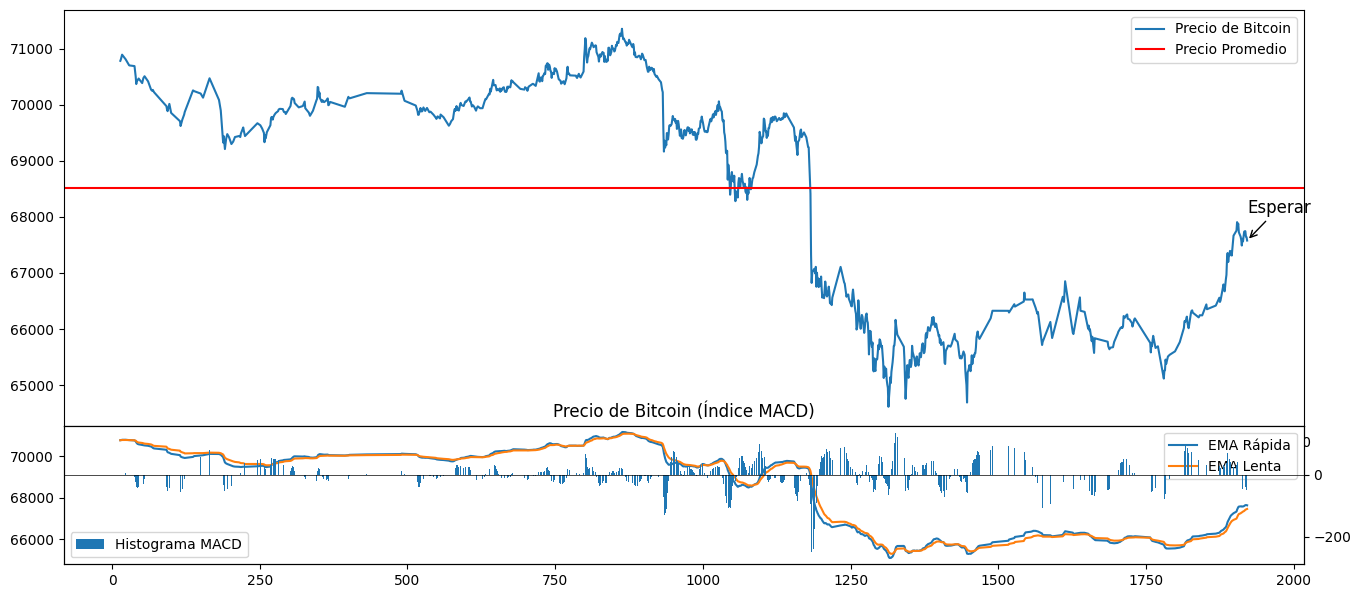

,Datetime,Open,High,Low,Close,Volume,Promedio
14,2024-03-29 01:10:00+00:00,70739.320312,70782.820312,70739.320312,70782.820312,28155904,68509.513734
15,2024-03-29 01:15:00+00:00,70796.898438,70825.890625,70796.898438,70811.328125,714752,68509.513734
17,2024-03-29 01:25:00+00:00,70896.500000,70896.500000,70879.500000,70892.765625,8206336,68509.513734
23,2024-03-29 01:55:00+00:00,70830.296875,70830.296875,70803.765625,70810.218750,1585152,68509.513734
29,2024-03-29 02:25:00+00:00,70754.625000,70754.625000,70701.593750,70701.593750,11763712,68509.513734


In [27]:
visualizacion_MACD()
df_bitcoin_limpio.head()

#Alerta por correo


In [22]:
import smtplib

def enviar_alerta_correo(decision):
    # Configuración del servidor SMTP y credenciales de correo
    servidor_smtp = "smtp.gmail.com"
    puerto_smtp = 587
    remitente = "tu_correo@gmail.com"
    destinatario = "destinatario@example.com"
    contraseña = "tu_contraseña"

    # Crear el mensaje
    asunto = "Alerta de trading"
    cuerpo = f"La señal de trading generada es: {decision}"
    mensaje = f"Subject: {asunto}\n\n{cuerpo}"

    # Enviar el correo electrónico
    try:
        servidor = smtplib.SMTP(servidor_smtp, puerto_smtp)
        servidor.starttls()
        servidor.login(remitente, contraseña)
        servidor.sendmail(remitente, destinatario, mensaje)
        print("Alerta enviada por correo electrónico")
    except Exception as e:
        print(f"Error al enviar el correo electrónico: {e}")
    finally:
        servidor.quit()

#Visualización

In [23]:
def visualizacion_EsMACD():
      global df_bitcoin_limpio, df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, precio_mas_bajo, precio_mas_alto, valor_estocastico, estado, decision
      df_bitcoin_limpio[['Promedio']] = media_bitcoin

          # Configurar el tamaño del gráfico en una proporción de 16x5
      plt.figure(figsize=(16, 5))

      # Adicionar un título al gráfico
      plt.title('Precio de Bitcoin vs. Precio Promedio (Indice MYC)')

      # Dibujar una línea con los datos del índice y la columna Close
      df_bitcoin_limpio['Close'].plot(label='Precio de Bitcoin')

      # Dibujar una línea con los datos del índice y la columna Promedio
      df_bitcoin_limpio['Promedio'].plot(label='Precio Promedio')

      # Mostrar un mensaje con la decisión del algoritmo
      plt.annotate(decision, xy=(df_bitcoin_limpio.index[-1], df_bitcoin_limpio['Close'].iloc[-1]),
                  xytext=(df_bitcoin_limpio.index[-1], df_bitcoin_limpio['Close'].iloc[-1] + 500),
                  arrowprops=dict(facecolor='black', arrowstyle='->'),
                  fontsize=12)

      # Mostrar el gráfico
      plt.legend()
      plt.show()


In [24]:
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc

def grafico_velas_volumen():
    global df_bitcoin_limpio
    # Convertir el índice a datetime
    df = df_bitcoin_limpio.copy()
    df.index = pd.to_datetime(df_bitcoin_limpio.index)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 9), gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

    # Gráfico de velas
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    candlestick_ohlc(ax1, np.column_stack([df_bitcoin_limpio.index, df[['Open', 'High', 'Low', 'Close']]]), width=0.6, colorup='green', colordown='red', alpha=0.8)
    ax1.set_title('Gráfico de velas y volumen de Bitcoin')
    ax1.set_xlabel('Fecha')
    ax1.set_ylabel('Precio (USD)')

    # Gráfico de volumen
    ax2.bar(df_bitcoin_limpio.index, df['Volume'], color='blue', alpha=0.5)
    ax2.set_title('Volumen de transacciones')
    ax2.set_xlabel('Fecha')
    ax2.set_ylabel('Volumen')

    plt.subplots_adjust(hspace=0.3)
    plt.show()

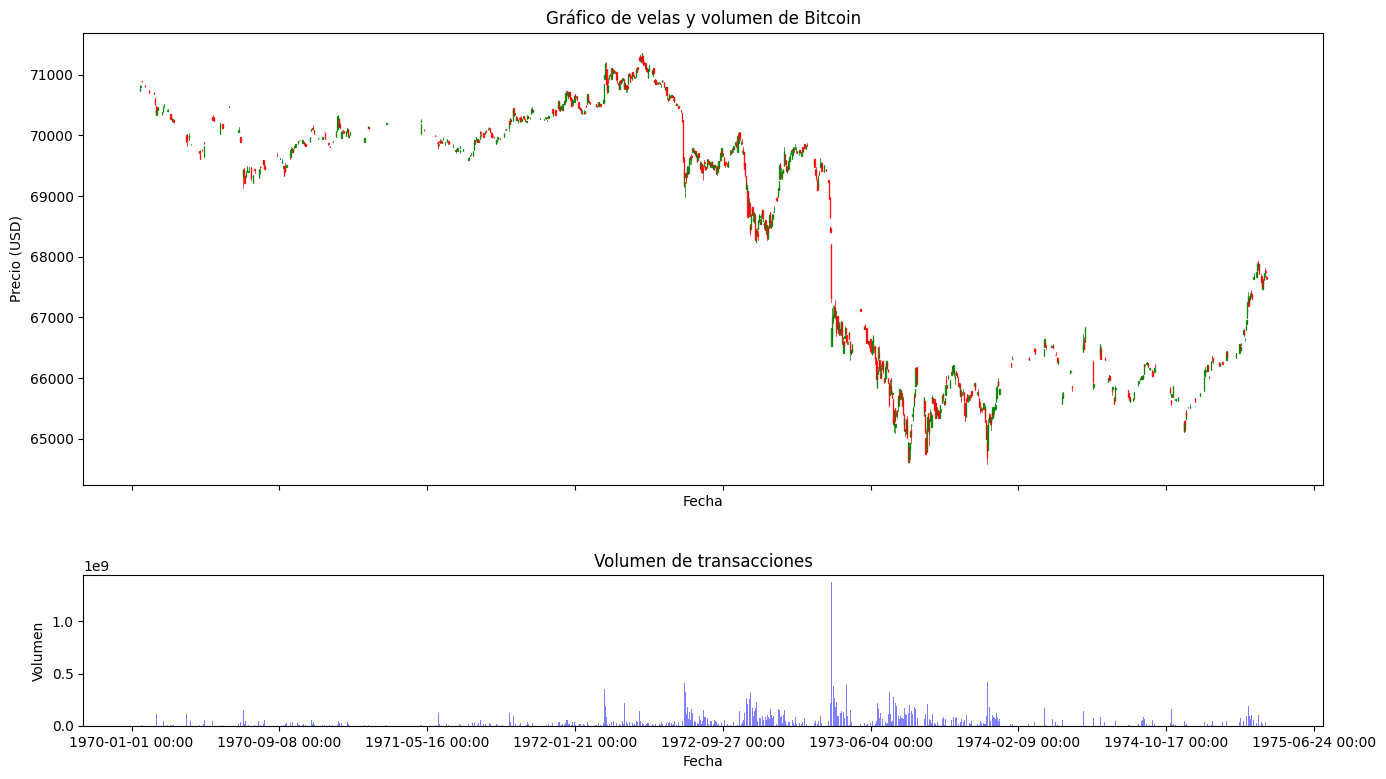

In [25]:
grafico_velas_volumen()


[*********************100%%**********************]  1 of 1 completed


El precio extraído de Binance es: $ 67,595.40 y la tendencia es Baja
El precio extraído de CoinMarket es: 67595.4 y la tendencia es Baja
Precio promedio del Bitcoin (Close): $68509.51
Utilizando el algoritmo básico
La recomendación es: Esperar


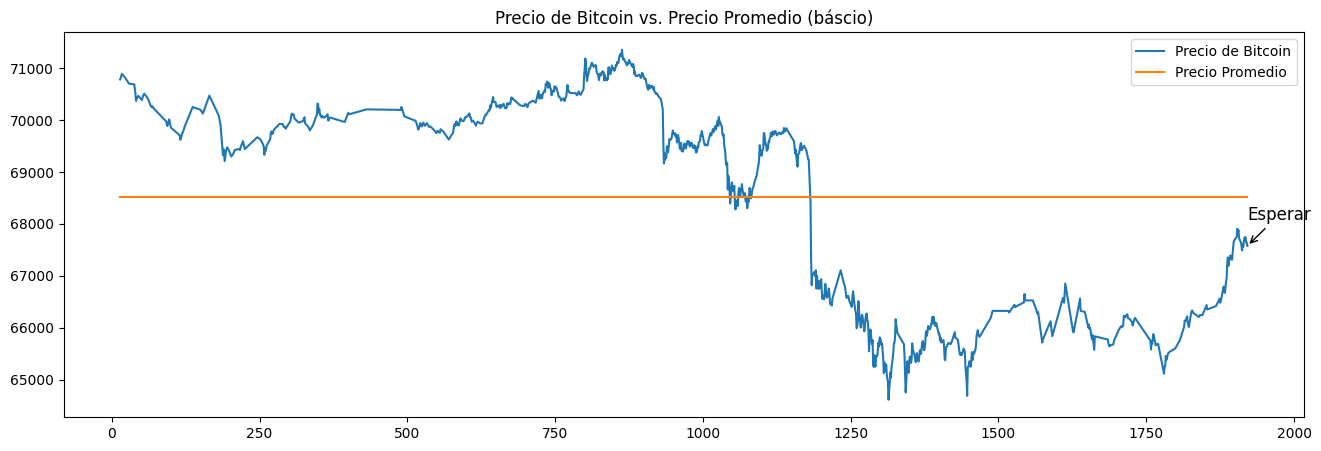

Utilizando el Oscilador Estocástico y el MACD
La recomendación es: Esperar


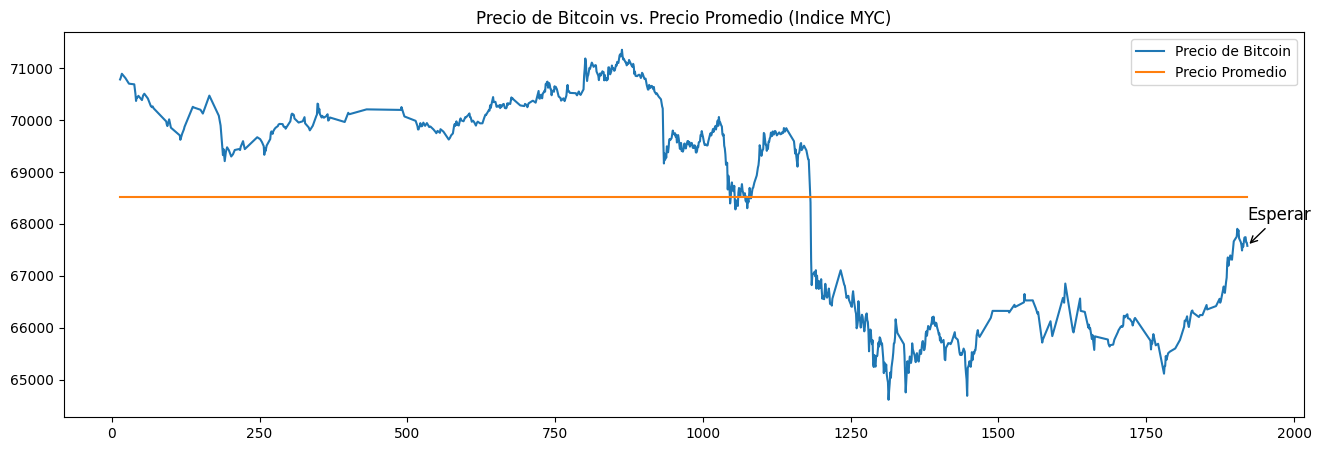

Número de periodos transcurridos: 16


KeyboardInterrupt: 

In [26]:
from IPython.display import clear_output

import time
contador= 0
while(True):
  clear_output()
  importar_base_bitcoin()
  importar_Binance()
  importar_CoinMarket()
  extraer_tendencia()
  limpieza_datos()
  tomar_decisiones()
  visualizacion_basica()
  precios_oscilador_estocastico()
  if len(precios_ultimos_14_periodos) == 14:
    tomar_decision_EsMACD()
    visualizacion_EsMACD()

  contador += 1

   # Imprime el número de periodos que han pasado
  print("Número de periodos transcurridos:", contador)
  time.sleep(300)